<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-Garethlomax/blob/data_curation/dataset_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS
We are constructing using the functions in the accompanying .py files as computer doesnt have enough ram to handle full dataset.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import random

# FUNCTIONS

In [0]:
def date_to_int_list(date):
    # date is in format yyyy-mm-dd

    y = int(date[0:4])
    m = int(date[5:7])
    d = int(date[8:10])

#    print("date is:")
#    print(y, " ",m, " ", d)
    return [y,m,d]

def monotonic_date(date, baseline = [1989, 1, 1]):

    date = date_to_int_list(date)
#    print(type(date[0]))
#    print(type(baseline[0]))
    # turns date since baseline start date into a monotonic function based on
    # year and months in line with pgm unit of analysis
    return date[1] - baseline[1] + ((date[0] - baseline[0]) * 12)



def construct_layer(dataframe, key, prio_key = "gid", debug = False):
    # returns 360 720 grid layer for a given parameter
    # should be given for one parameter per year.
    array = np.zeros(360*720)
    prio_grid = dataframe[prio_key]
    for i in range(len(prio_grid)):
        j = prio_grid.iloc[i] - 1
        """change the below to only be in the case it isnt nan""" # will this cause problems?
        array[j] += dataframe[key].iloc[i]
    array.resize(360,720)

    return array

def construct_combined_sequence(dataframe_prio, dataframe_ucdp, key_list_prio, key_list_ucdp, start = [1989, 1,1], stop = [2014,1,1]):
    stop  = '2014-01-01'
    # need to adapt ged and other year / month vs ged database for this.
    # bool prio to add multiples of 12 to each year usin prio grid.
    num_month = monotonic_date(stop, start)
    print(num_month)
    comb_channel_len = len(key_list_prio) + len(key_list_ucdp)
    print(comb_channel_len)
    array = np.zeros((num_month, comb_channel_len, 360,720))

    stop = date_to_int_list(stop)

    month = 0
    for i in range(start[0], stop[0]):
        for j in range(12): # for each month
            # now fill in selected channels as requried.

            array[month][:len(key_list_ucdp)] = construct_channels(dataframe_ucdp[dataframe_ucdp.mon_month == month], key_list = key_list_ucdp, prio_key = "priogrid_gid")
            array[month][len(key_list_ucdp):] = construct_channels(dataframe_prio[dataframe_prio.year == i], key_list = key_list_prio, prio_key = 'gid')
            print(month)

            month += 1
    del month
    return array



def construct_channels(dataframe, key_list, prio_key = "gid"):
    # usually used for prio
    array = np.zeros((len(key_list), 360, 720))
    for i, keys in enumerate(key_list):
        array[i] = construct_layer(dataframe, key = keys, prio_key = prio_key)
    return array


"""check how we are dealing with cases that go up to and including the final step"""

def construct_sequence(dataframe, key_list, prio_key = 'gid', start = [1989, 1, 1], stop = [2014,1,1], prio = False):
    stop  = '2014-01-01'
    # need to adapt ged and other year / month vs ged database for this.
    # bool prio to add multiples of 12 to each year usin prio grid.
    num_month = monotonic_date(stop, start)




    if prio == False:
        # i.e if doing ucdp
        # presumes adapted ucdp
        # seq length, channels, height, width
        array = np.zeros((num_month, len(key_list), 360, 720))

        for month in range(num_month):
            array[month] = construct_channels(dataframe[dataframe.mon_month == month], key_list = key_list, prio_key = "priogrid_gid")

            # now for
#            array[i] =
    elif prio:
        stop = [2014,1,1]
        array = np.zeros((num_month, len(key_list), 360, 720))
        # now for the prio grid data.
        # need to make up remainder of start year,
        # then multiples of 12 for each year
        # then remainder of end year.

        """this presumes start dates @ start of year no more no less"""
        # need to plus one at the end
        month = 0
        for i in range(start[0], stop[0]):
            for j in range(12): # for each month
                array[month] = construct_channels(dataframe[dataframe.year == i], key_list = key_list, prio_key = 'gid')
                print(month)

                month += 1
        del month





#        start_months = 13 - start[1] # i.e if its 1989,1,1 then there are 12 months left.
#        years = stop[0] - start[0]  - 1 # -1 as due to method of making up start months. i.e
#        # want [2013,1,1] [2014,1,1] to be dependant of start and stop months and have no year * 12 months additions
#        finish_months = stop[1] # stop months
#        months_interim = np.arange(start[0], stop[0]+1, 1)
#
#        ######
#
#        # now the start month multiples
#        for i in range(start_months):
#            array[i] = construct_channels(dataframe[dataframe.year == start[0]], key_list = key_list, prio_key = "gid")
#        # double check prio yearly - try to get monthly values out.
#
#        for i in range(years):
#            for j in range(i *12, (i+1)* 12):
#                array[j]


    return array


def date_column(dataframe, baseline = [1989,1,1]):
    # puts new column on dataframe, no need to return.
    # date start just as dummy atm
#    dataframe = dataframe["date_start"]
    vals = dataframe["date_start"].values
    new_col = np.array([monotonic_date(string_date) for string_date in vals])
    dataframe["mon_month"] = new_col

def h5py_conversion(data_array, filename, key_list_ucdp, key_list_prio):
    # this is for saving the default 360:720 file to chop out of.
    # lazy loading saves the day
    # all day
    # every day
    f = h5py.File("{}.hdf5".format(filename), "w")

    f.create_dataset("data_combined", data = data_array)

    f.close()



    csv = open(name + "_config.csv", 'w')
    csv.write("Included data UCDP:\n")
    for key in key_list_ucdp:
        csv.write(key + "\n")

    csv.write("Included data PRIO:\n")
    for key in key_list_prio:
        csv.write(key + "\n")
    csv.close()


In [0]:
def raster_test(input_data, chunk_size = 16):
    # to overcome edge sizes can make selection large if we just reject the training data for outside africa
    # although we do not necessarily need to do this
    # i.e expand box and allow less sampled box to sampel others more frequently.

    # step size is always 1
    # assuming image is a cutout of globe
    # this is for single step, single channel as a test.
    step = 1
    height = input_data.shape[-2]
    width = input_data.shape[-1]
    for i in range(height - chunk_size + 1):
        for j in range(width - chunk_size+1):
            print(input_data[:,i:i+chunk_size,j:j + chunk_size])
            print(".")

#    plt.imshow(input_data)

def raster_selection(input_data, chunk_size = 16):
    # here input_data is sequence step.
    # data should be of dimensions seq, channels, height, width.
    # to overcome edge sizes can make selection large if we just reject the training data for outside africa
    # although we do not necessarily need to do this
    # i.e expand box and allow less sampled box to sampel others more frequently.

    # step size is always 1
    # assuming image is a cutout of globe
    # this is for single step, single channel as a test.
    step = 1
    height = input_data.shape[-2]
    width = input_data.shape[-1]
    # this is not efficient.
    for i in range(height - chunk_size + 1):
        for j in range(width - chunk_size+1):
            input_data[0][i:i+chunk_size,j:j + chunk_size]

    plt.imshow(input_data)


def random_pixel_bounds(i, j, chunk_size = 16):
    # returns the bounds of the image to select with a random pixel size.

    height = random.randint(0, chunk_size-1)
    width = random.randint(0, chunk_size-1)
    # this randomly generates a of the image for where the pixel may be located
    # randomly in the cut out image.
    i_lower = i - height
    i_upper = i + (chunk_size - height)

    j_lower = j - width
    j_upper = j + (chunk_size - width)

    return [i_lower, i_upper, j_lower, j_upper]

def random_selection(image, i, j, chunk_size = 16):

    i_lower, i_upper, j_lower, j_upper = random_pixel_bounds(i, j, chunk_size = chunk_size)

    print(image[i_lower:i_upper,j_lower:j_upper])

def random_grid_selection(image, sequence_step, chunk_size= 16, draws = 5, debug = True):
    if debug:
        print("Image shape is:" , image.shape)


    # decide if this is going to be h5py loaded.

    # decide what sequence step is going to be like and how to return it

    # image is seq, channels, height, width

    # here we are using a seq length of 10. - could use 12 but atm we go for 10.

    # sequence step is the step at which the TRUTH is being extracted. the predictor sequence
    # is extracted from the 10 preceding steps. be careful to send in from i > 11
    assert sequence_step > 10, ("This function selects the datapoints from this test set that contain"
                                "a conflict event and then selects predictor data from the 10 preceding steps"
                                " as a result i > 10 must be true")
    # for sequence step, 0th layer - i.e fatalities
    y, x = np.where(image[sequence_step][0] >= 1)

    if debug:
        print(x.shape)

    truth_list = []
    predictor_list = []

    # re arange for loops for speed?
    for i,j in zip(y, x): # now over sites where fatalities have occured
        for _ in range(draws):
            i_lower, i_upper, j_lower, j_upper = random_pixel_bounds(i, j, chunk_size=chunk_size)

            # now need to work out how to store these. how to stack ontop ect.
            truth = image[sequence_step][0,i_lower:i_upper,j_lower:j_upper]
            # check these dimensions
            predictors = image[i-10:i, :,i_lower:i_upper,j_lower:j_upper]

            truth_list.append(truth)
            predictor_list.append(predictors)

    # finally we combine the previous arrays.

    return np.stack(predictor_list, axis= 0), np.stack(truth_list, axis = 0)


def full_dataset_numpy(image, chunk_size = 16, draws = 5, debug = False):
    # image is seq, channels, height, width
    predictor_list = []
    truth_list = []
    for i in range(11, len(image)):
        t1, t2 = random_grid_selection(image, i)
        predictor_list.append(t1)
        truth_list.append(t2)

    truth_np = np.concatenate(truth_list, axis = 0)
    predictor_np = np.concatenate(predictor_list, axis =0)
    return predictor_np, truth_np

def quick_dataset(data, name):
    f = h5py.File(name + ".hdf5", "w")
    f.create_dataset("main", data = data)
#    f.create_dataset("truth", data = truth)
    f.close()




#data = pd.read_csv("data/ged191.csv")

def debug_func1(dataframe, month):
    a = dataframe[dataframe.mon_month == month]
    print(len(a[a.best >0]))


In [0]:
def raster_test(input_data, chunk_size = 16):
    # to overcome edge sizes can make selection large if we just reject the training data for outside africa
    # although we do not necessarily need to do this
    # i.e expand box and allow less sampled box to sampel others more frequently.

    # step size is always 1
    # assuming image is a cutout of globe
    # this is for single step, single channel as a test.
    step = 1
    height = input_data.shape[-2]
    width = input_data.shape[-1]
    for i in range(height - chunk_size + 1):
        for j in range(width - chunk_size+1):
            print(input_data[:,i:i+chunk_size,j:j + chunk_size])
            print(".")

#    plt.imshow(input_data)

def raster_selection(input_data, chunk_size = 16):
    # here input_data is sequence step.
    # data should be of dimensions seq, channels, height, width.
    # to overcome edge sizes can make selection large if we just reject the training data for outside africa
    # although we do not necessarily need to do this
    # i.e expand box and allow less sampled box to sampel others more frequently.

    # step size is always 1
    # assuming image is a cutout of globe
    # this is for single step, single channel as a test.
    step = 1
    height = input_data.shape[-2]
    width = input_data.shape[-1]
    # this is not efficient.
    for i in range(height - chunk_size + 1):
        for j in range(width - chunk_size+1):
            input_data[0][i:i+chunk_size,j:j + chunk_size]

    plt.imshow(input_data)


def random_pixel_bounds(i, j, chunk_size = 16):
    # returns the bounds of the image to select with a random pixel size.

    height = random.randint(0, chunk_size-1)
    width = random.randint(0, chunk_size-1)
    # this randomly generates a of the image for where the pixel may be located
    # randomly in the cut out image.
    i_lower = i - height
    i_upper = i + (chunk_size - height)

    j_lower = j - width
    j_upper = j + (chunk_size - width)

    return [i_lower, i_upper, j_lower, j_upper]

def random_selection(image, i, j, chunk_size = 16):

    i_lower, i_upper, j_lower, j_upper = random_pixel_bounds(i, j, chunk_size = chunk_size)

    print(image[i_lower:i_upper,j_lower:j_upper])

def random_grid_selection(image, sequence_step, chunk_size= 16, draws = 5, debug = True):
    if debug:
        print("Image shape is:" , image.shape)


    # decide if this is going to be h5py loaded.

    # decide what sequence step is going to be like and how to return it

    # image is seq, channels, height, width

    # here we are using a seq length of 10. - could use 12 but atm we go for 10.

    # sequence step is the step at which the TRUTH is being extracted. the predictor sequence
    # is extracted from the 10 preceding steps. be careful to send in from i > 11
    assert sequence_step > 10, ("This function selects the datapoints from this test set that contain"
                                "a conflict event and then selects predictor data from the 10 preceding steps"
                                " as a result i > 10 must be true")
    # for sequence step, 0th layer - i.e fatalities
    y, x = np.where(image[sequence_step][0] >= 1)

    if debug:
        print(x.shape)

    truth_list = []
    predictor_list = []

    # re arange for loops for speed?
    for i,j in zip(y, x): # now over sites where fatalities have occured
        for _ in range(draws):
            i_lower, i_upper, j_lower, j_upper = random_pixel_bounds(i, j, chunk_size=chunk_size)

            # now need to work out how to store these. how to stack ontop ect.
            truth = image[sequence_step][0,i_lower:i_upper,j_lower:j_upper]
            # check these dimensions
            predictors = image[i-10:i, :,i_lower:i_upper,j_lower:j_upper]

            truth_list.append(truth)
            predictor_list.append(predictors)

    # finally we combine the previous arrays.

    return np.stack(predictor_list, axis= 0), np.stack(truth_list, axis = 0)


def full_dataset_numpy(image, chunk_size = 16, draws = 5, debug = False):
    # image is seq, channels, height, width
    predictor_list = []
    truth_list = []
    for i in range(11, len(image)):
        t1, t2 = random_grid_selection(image, i)
        predictor_list.append(t1)
        truth_list.append(t2)

    truth_np = np.concatenate(truth_list, axis = 0)
    predictor_np = np.concatenate(predictor_list, axis =0)
    return predictor_np, truth_np

def quick_dataset(data, name):
    f = h5py.File(name + ".hdf5", "w")
    f.create_dataset("main", data = data)
#    f.create_dataset("truth", data = truth)
    f.close()




#data = pd.read_csv("data/ged191.csv")

def debug_func1(dataframe, month):
    a = dataframe[dataframe.mon_month == month]
    print(len(a[a.best >0]))


# LOADING DATA AND FUNCTION

In [6]:
%pwd

'/content'

In [7]:
%cd /content/drive/My\ Drive/masters_project/

/content/drive/My Drive/masters_project


load in data

In [0]:

data_prio = pd.read_csv("data/PRIO-GRID Yearly Variables for 1946-2014 - 2019-07-26.csv")
data_ucdp = pd.read_csv("data/ged191.csv")



add monotonic month column to the ucdp data

In [0]:
date_column(data_ucdp)

construct full image sequence

In [10]:
test = construct_combined_sequence(data_prio, data_ucdp, key_list_prio=['prec_gpcc','pop_hyd_sum'], key_list_ucdp=['best'])

300
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


saving 

In [0]:
np.save("saved_array", test)

now put this into our random selection.

In [12]:
test.shape


(300, 3, 360, 720)

In [0]:
def full_dataset_h5py(image, filename, chunk_size = 16, draws = 5, debug = False):
    """ dataset is too large to combine in 12gb of ram - need to combine in h5py
    array. i.e lazy saving as well as lazy loading"""
    
    with h5py.File(filename + ".hdf5", 'w') as f:
        for i in range(11, len(image)):
            t1, t2 = random_grid_selection(image, i)
            if i == 11:
                # creat h5py file at first step.
                f.create_dataset('predictor', data= t1, maxshape=(None,None, None, None,None)) # compression="gzip", chunks=True, taken out
                f.create_dataset("truth", data= t2, maxshape=(None,None,None))
        
            else:
                f["predictor"].resize((f["predictor"].shape[0] + t1.shape[0]), axis = 0) # expand dataset
                f["truth"].resize((f["truth"].shape[0] + t2.shape[0]), axis = 0)
            
                f["predictor"][-t1.shape[0]:] = t1 # place new data in expanded dataset
                f["truth"][-t2.shape[0]:] = t2
    
#     f.close()
        

In [24]:
# a, b = full_dataset_numpy(test)
# full_dataset_h5py(test, "test_run_full_dataset3")


Image shape is: (300, 3, 360, 720)
(106,)
Image shape is: (300, 3, 360, 720)
(181,)
Image shape is: (300, 3, 360, 720)
(122,)
Image shape is: (300, 3, 360, 720)
(140,)
Image shape is: (300, 3, 360, 720)
(145,)
Image shape is: (300, 3, 360, 720)
(131,)
Image shape is: (300, 3, 360, 720)
(126,)
Image shape is: (300, 3, 360, 720)
(116,)
Image shape is: (300, 3, 360, 720)
(96,)
Image shape is: (300, 3, 360, 720)
(115,)
Image shape is: (300, 3, 360, 720)
(143,)
Image shape is: (300, 3, 360, 720)
(124,)
Image shape is: (300, 3, 360, 720)
(104,)
Image shape is: (300, 3, 360, 720)
(145,)
Image shape is: (300, 3, 360, 720)
(104,)
Image shape is: (300, 3, 360, 720)
(128,)
Image shape is: (300, 3, 360, 720)
(130,)
Image shape is: (300, 3, 360, 720)
(147,)
Image shape is: (300, 3, 360, 720)
(109,)
Image shape is: (300, 3, 360, 720)
(123,)
Image shape is: (300, 3, 360, 720)
(112,)
Image shape is: (300, 3, 360, 720)
(124,)
Image shape is: (300, 3, 360, 720)
(129,)
Image shape is: (300, 3, 360, 720)


In [0]:



f = h5py.File("test_run_full_dataset3.hdf5", 'r')


In [29]:
f["predictor"].shape



(248580, 10, 3, 16, 16)

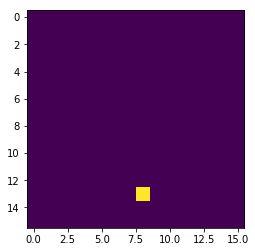

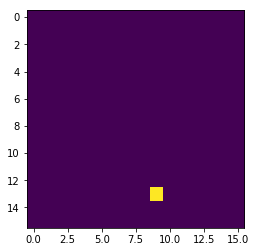

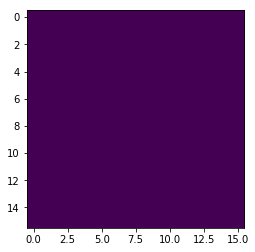

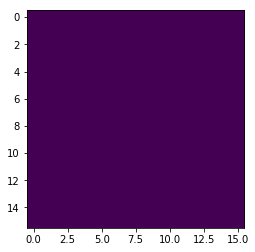

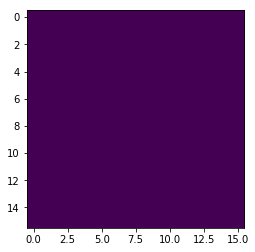

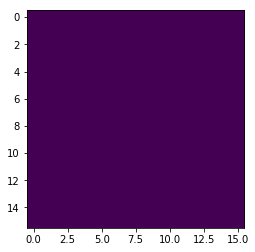

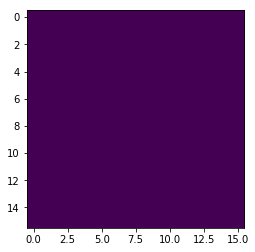

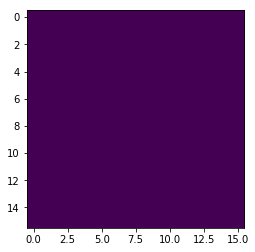

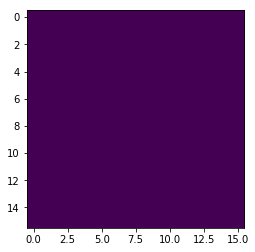

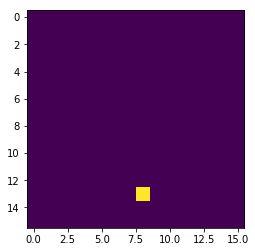

In [58]:
f["predictor"].shape

for i in range(10):
    plt.figure()
    plt.imshow(f["predictor"][1][i][0])
    

In [46]:
f["predictor"].shape
k = 0
for i in range(248580):
    k +=1
print("done")


done


In [61]:
len(np.where(f["predictor"][1][:,0] > 0))

def data_set_analysis(dataset):
    dat = np.zeros(len(dataset["predictor"]))
    for i in range(len(dataset["predictor"])):
        dat[i] = len(np.where(f["predictor"][i][:,0] > 0))
    return dat

dats = data_set_analysis(f)
    

3

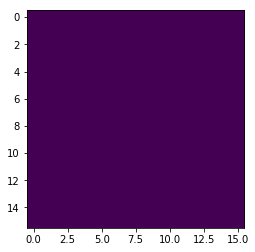

In [56]:
f["predictor"][0][:,0][0].shape
plt.imshow(f["predictor"][0][:,0][0])